# Introduction to Artificial Neural Networks
## Assignment #1
### Rhichard Koh

In [65]:
# importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import numpy as np
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.layers import Dense, Dropout
import keras_tuner as kt
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, TensorBoard
import datetime

In [2]:
# loading the dataset
df = pd.read_csv('insurance.csv')

In [3]:
# preview of the dataset
df.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

In [4]:
# looking for missing values
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

We do not have missing values.

In [5]:
# checking for duplicates
df.duplicated().sum()

1

we found 1 duplicate

In [6]:
# drop the duplicated row
df = df.drop_duplicates()

In [7]:
# checking if it was properly dropped
df.duplicated().sum()

0

It was properly dropped

# 1. Perform an extensive exploratory data analysis (EDA) and provide the preliminary investigation of the dataset by discovering at least five patterns in the data.

Text(0.5, 0, 'Charges in $')

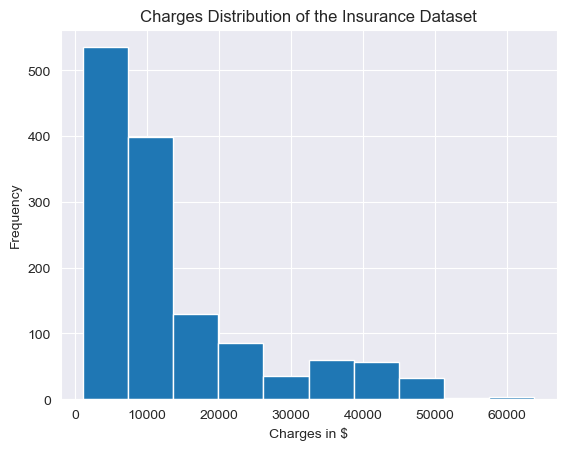

In [8]:
# looking at the target variable frequency distribution
df.charges.plot(kind='hist')
plt.title('Charges Distribution of the Insurance Dataset')
plt.xlabel('Charges in $')

We can see the the target variable ('charges') is right skewed biasing lower charges.

In [9]:
# looking at feature correlation
df.corr()

C:\Users\xxryk\AppData\Local\Temp\ipykernel_33872\2997517593.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


age       bmi  children   charges
age       1.000000  0.109344  0.041536  0.298308
bmi       0.109344  1.000000  0.012755  0.198401
children  0.041536  0.012755  1.000000  0.067389
charges   0.298308  0.198401  0.067389  1.000000

C:\Users\xxryk\AppData\Local\Temp\ipykernel_33872\674687443.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True)


<Axes: >

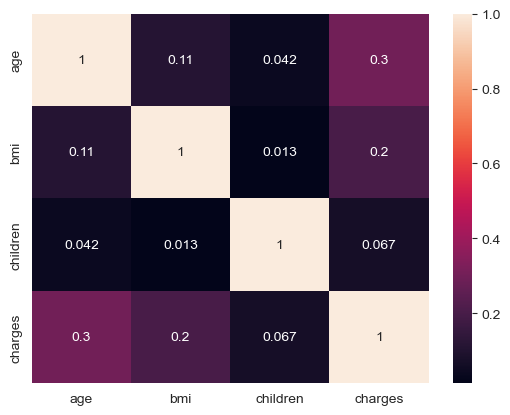

In [10]:
# making a nice image for the correlation of features.
sns.heatmap(df.corr(),annot=True)

When we look at the correlation heatmap, we can see the highest correlation with our target variable ('charges') is our age feature, and the least correlated with our target variable is the number of children.

In [11]:
# looking at the frequency of occurrence for the categorical columns without taking into account the continuous vals
unique_vals_count = df.select_dtypes(exclude=np.number).value_counts()
unique_vals_count = unique_vals_count.to_frame().reset_index()
unique_vals_count.columns = ['sex', 'smoker', 'region', 'count']
unique_vals_count

sex smoker     region  count
0   female     no  southwest    141
1   female     no  southeast    139
2   female     no  northwest    135
3     male     no  southeast    134
4   female     no  northeast    132
5     male     no  northwest    131
6     male     no  southwest    126
7     male     no  northeast    125
8     male    yes  southeast     55
9     male    yes  northeast     38
10    male    yes  southwest     37
11  female    yes  southeast     36
12  female    yes  northeast     29
13  female    yes  northwest     29
14    male    yes  northwest     29
15  female    yes  southwest     21

We can see that the most frequent population is a non-smoking female from the south-west region. The rarest is a smoking make from south-west

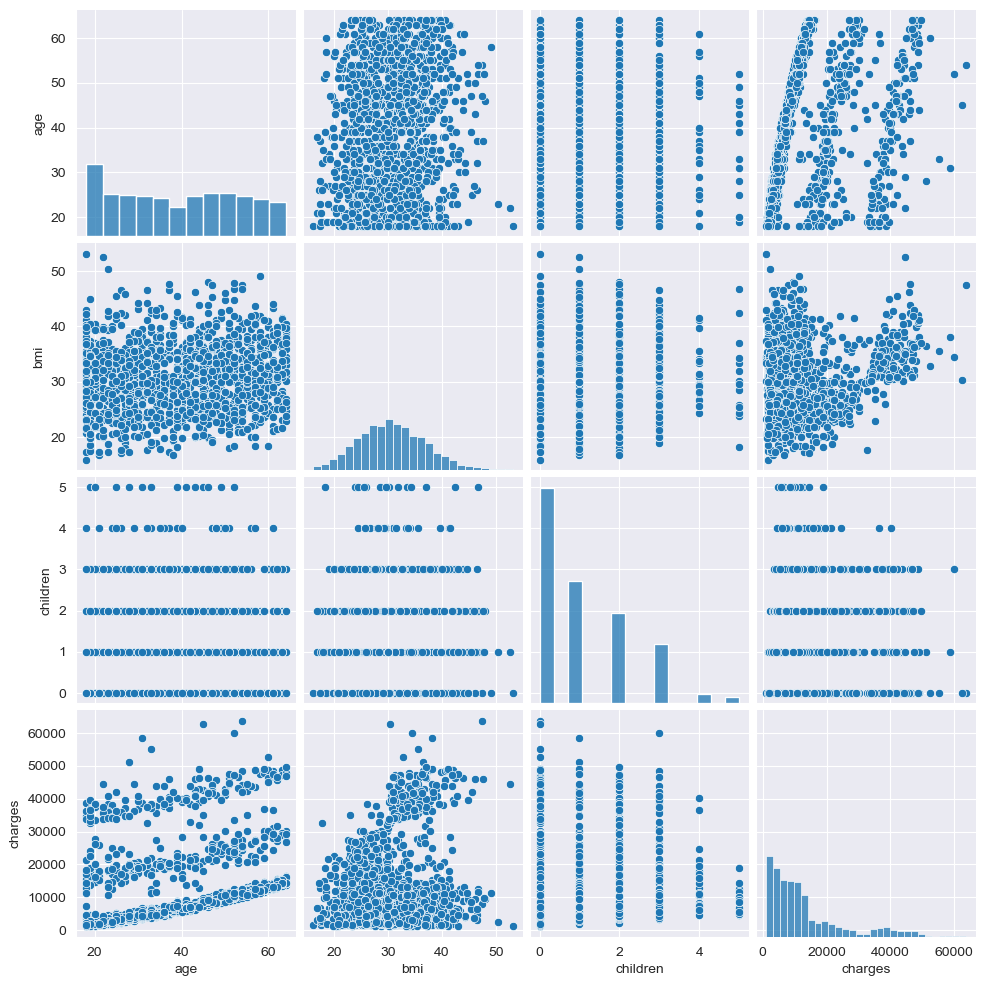

In [12]:
# looking at feature correlation
sns.pairplot(df)

Text(0, 0.5, 'Frequency')

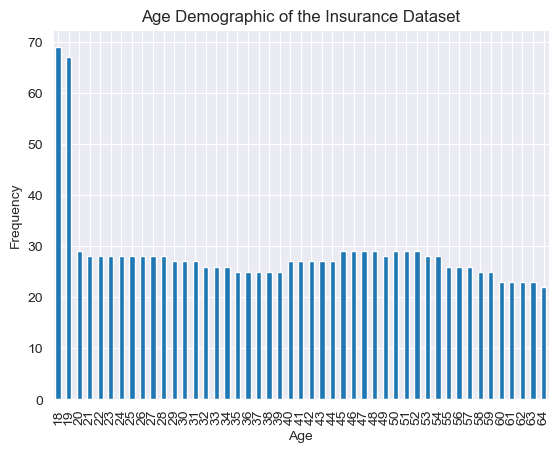

In [13]:
# looking at the age demographic of the dataset
df['age'].value_counts().sort_index().plot(kind='bar')
plt.title('Age Demographic of the Insurance Dataset')
plt.xlabel('Age')
plt.ylabel('Frequency')

We can see that the most frequent occurring age in the dataset are 18-19 year olds. From 20-64 it is about evenly distributed.

In [14]:
# looking at the count, mean, std, min, 25%, 50%, 75%, and max of the target variable
df.charges.describe()

count     1337.000000
mean     13279.121487
std      12110.359656
min       1121.873900
25%       4746.344000
50%       9386.161300
75%      16657.717450
max      63770.428010
Name: charges, dtype: float64

Text(0, 0.5, 'Frequency')

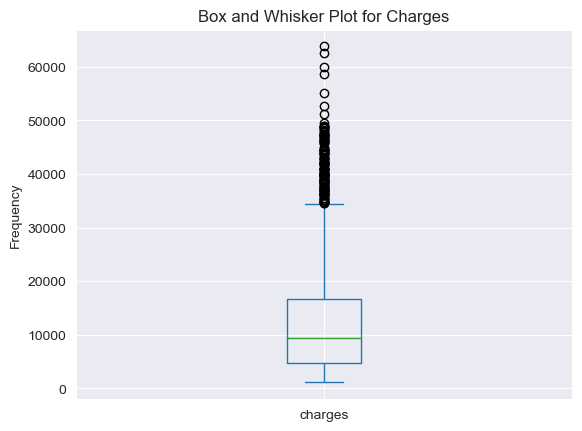

In [15]:
# plotting the mean, std, min, 25%, 50%, 75%, and max of the target variable
df.charges.plot(kind='box')
plt.title('Box and Whisker Plot for Charges')
plt.ylabel('Frequency')

Text(0.5, 1.0, 'Comparing Sex and Smoking occurance')

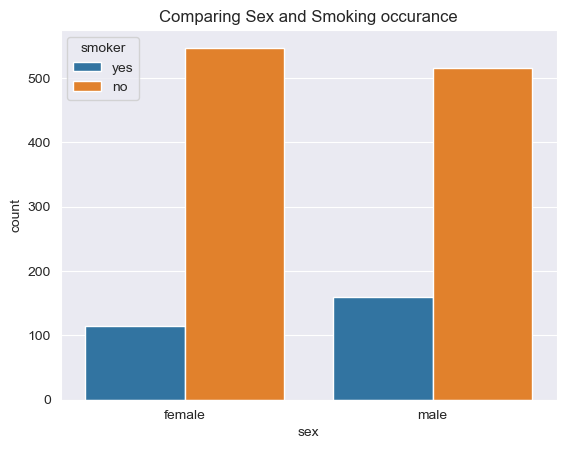

In [16]:
# looking at which sex has a higher smoking frequency
sns.countplot(df,x='sex',hue='smoker')
plt.title('Comparing Sex and Smoking occurance')

There are more male smokers rather than female smokers according to the insurance dataset

Text(0.5, 1.0, 'Frequency of each Sex from each Region')

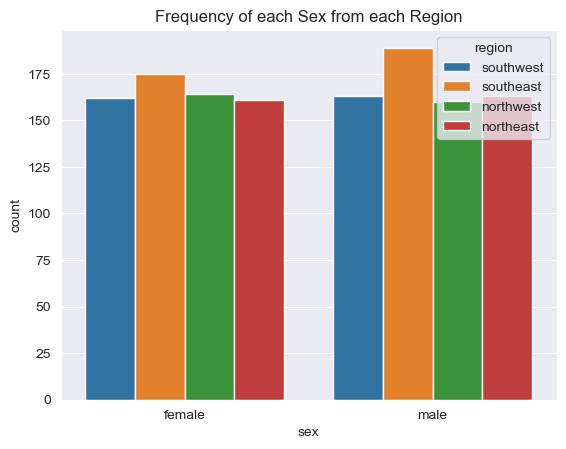

In [17]:
# viewing how many females, and males we have from each region
sns.countplot(df,x='sex',hue='region')
plt.title('Frequency of each Sex from each Region')

After viewing the frequency of females males from each region, it is safe to assume we have a pretty well balanced dataset for the sex feature.

<Axes: xlabel='region', ylabel='count'>

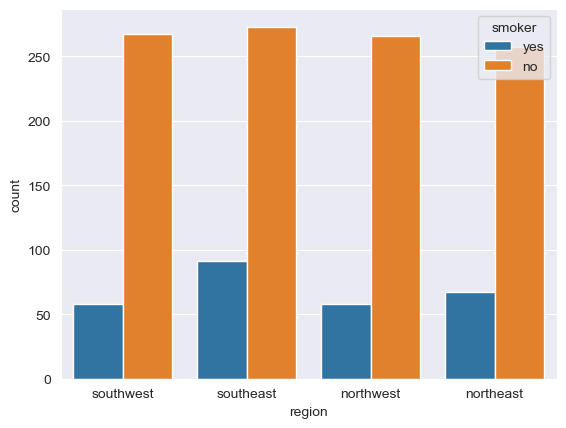

In [18]:
# plotting the frequency of smokers in each region
sns.countplot(df,x='region',hue='smoker')

After viewing the plot we can say that we have a normal distribution of smokers in each region, it is balanced. However, we have much more non-smokers vs smokers in our whole dataset.

In [19]:
# encoding the sex and smoker features into binary
sex_map = {
    'female':0,
    'male':1
}

smoker_map = {
    'no':0,
    'yes':1
}

df.smoker = df.smoker.map(smoker_map)
df.sex = df.sex.map(sex_map)

I just used map to encode this vs one-hot because since there is only two options it is easier to map the binary classes to 0 and 1.

In [20]:
df_encoded = pd.get_dummies(df, columns = ['region'])

I had to use one-hot encoding for the region feature because it does not have an order and rank, so I must split the feature into 4 separate features and one-hot encode it for best practices.

In [21]:
df_encoded.head()

age  sex     bmi  children  smoker      charges  region_northeast  \
0   19    0  27.900         0       1  16884.92400                 0   
1   18    1  33.770         1       0   1725.55230                 0   
2   28    1  33.000         3       0   4449.46200                 0   
3   33    1  22.705         0       0  21984.47061                 0   
4   32    1  28.880         0       0   3866.85520                 0   

   region_northwest  region_southeast  region_southwest  
0                 0                 0                 1  
1                 0                 1                 0  
2                 0                 1                 0  
3                 1                 0                 0  
4                 1                 0                 0

<Axes: >

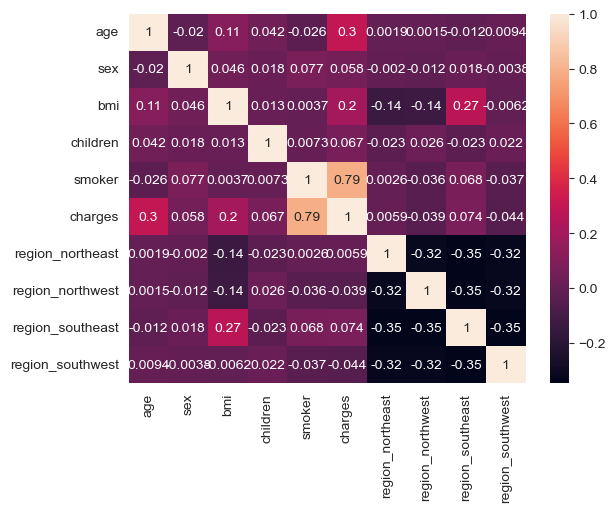

In [22]:
# view the correlation of the updated encoded dataset
sns.heatmap(df_encoded.corr(), annot=True)

We can now view that the highest feature that positively correlates to our target variable is smoker instead of age. It also has a significantly more correlation than age. Another correlation we see is the in the region of southeast it has a high correlation with bmi meaning their region's bmi must be higher than all the other regions, and bmi has a 0.2 correlation with charges making this quite important

Text(0, 0.5, 'Average BMI')

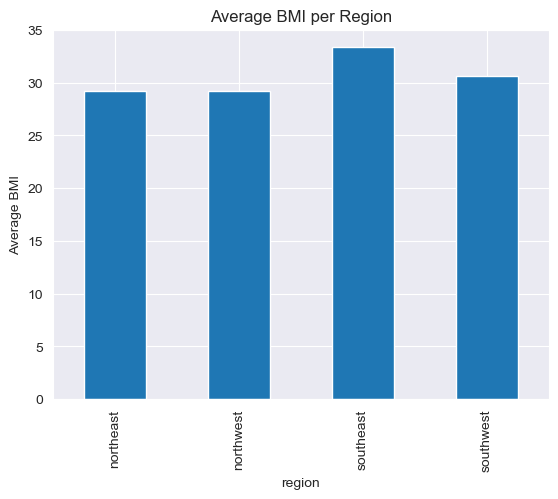

In [23]:
# viewing the average bmi of each region
df.groupby('region').mean()['bmi'].plot(kind='bar')
plt.title('Average BMI per Region')
plt.ylabel('Average BMI')

We can see that the south-east region does indeed have the highest bmi average compared to all the other regions.

Text(0, 0.5, 'Average Charge in $')

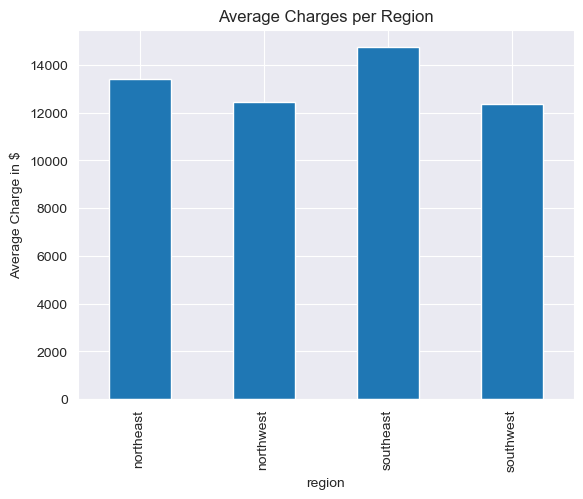

In [24]:
df.groupby('region').mean()['charges'].plot(kind='bar')
plt.title('Average Charges per Region')
plt.ylabel('Average Charge in $')

Because the highest average BMI region is south-east, it is also has the highest average charged.

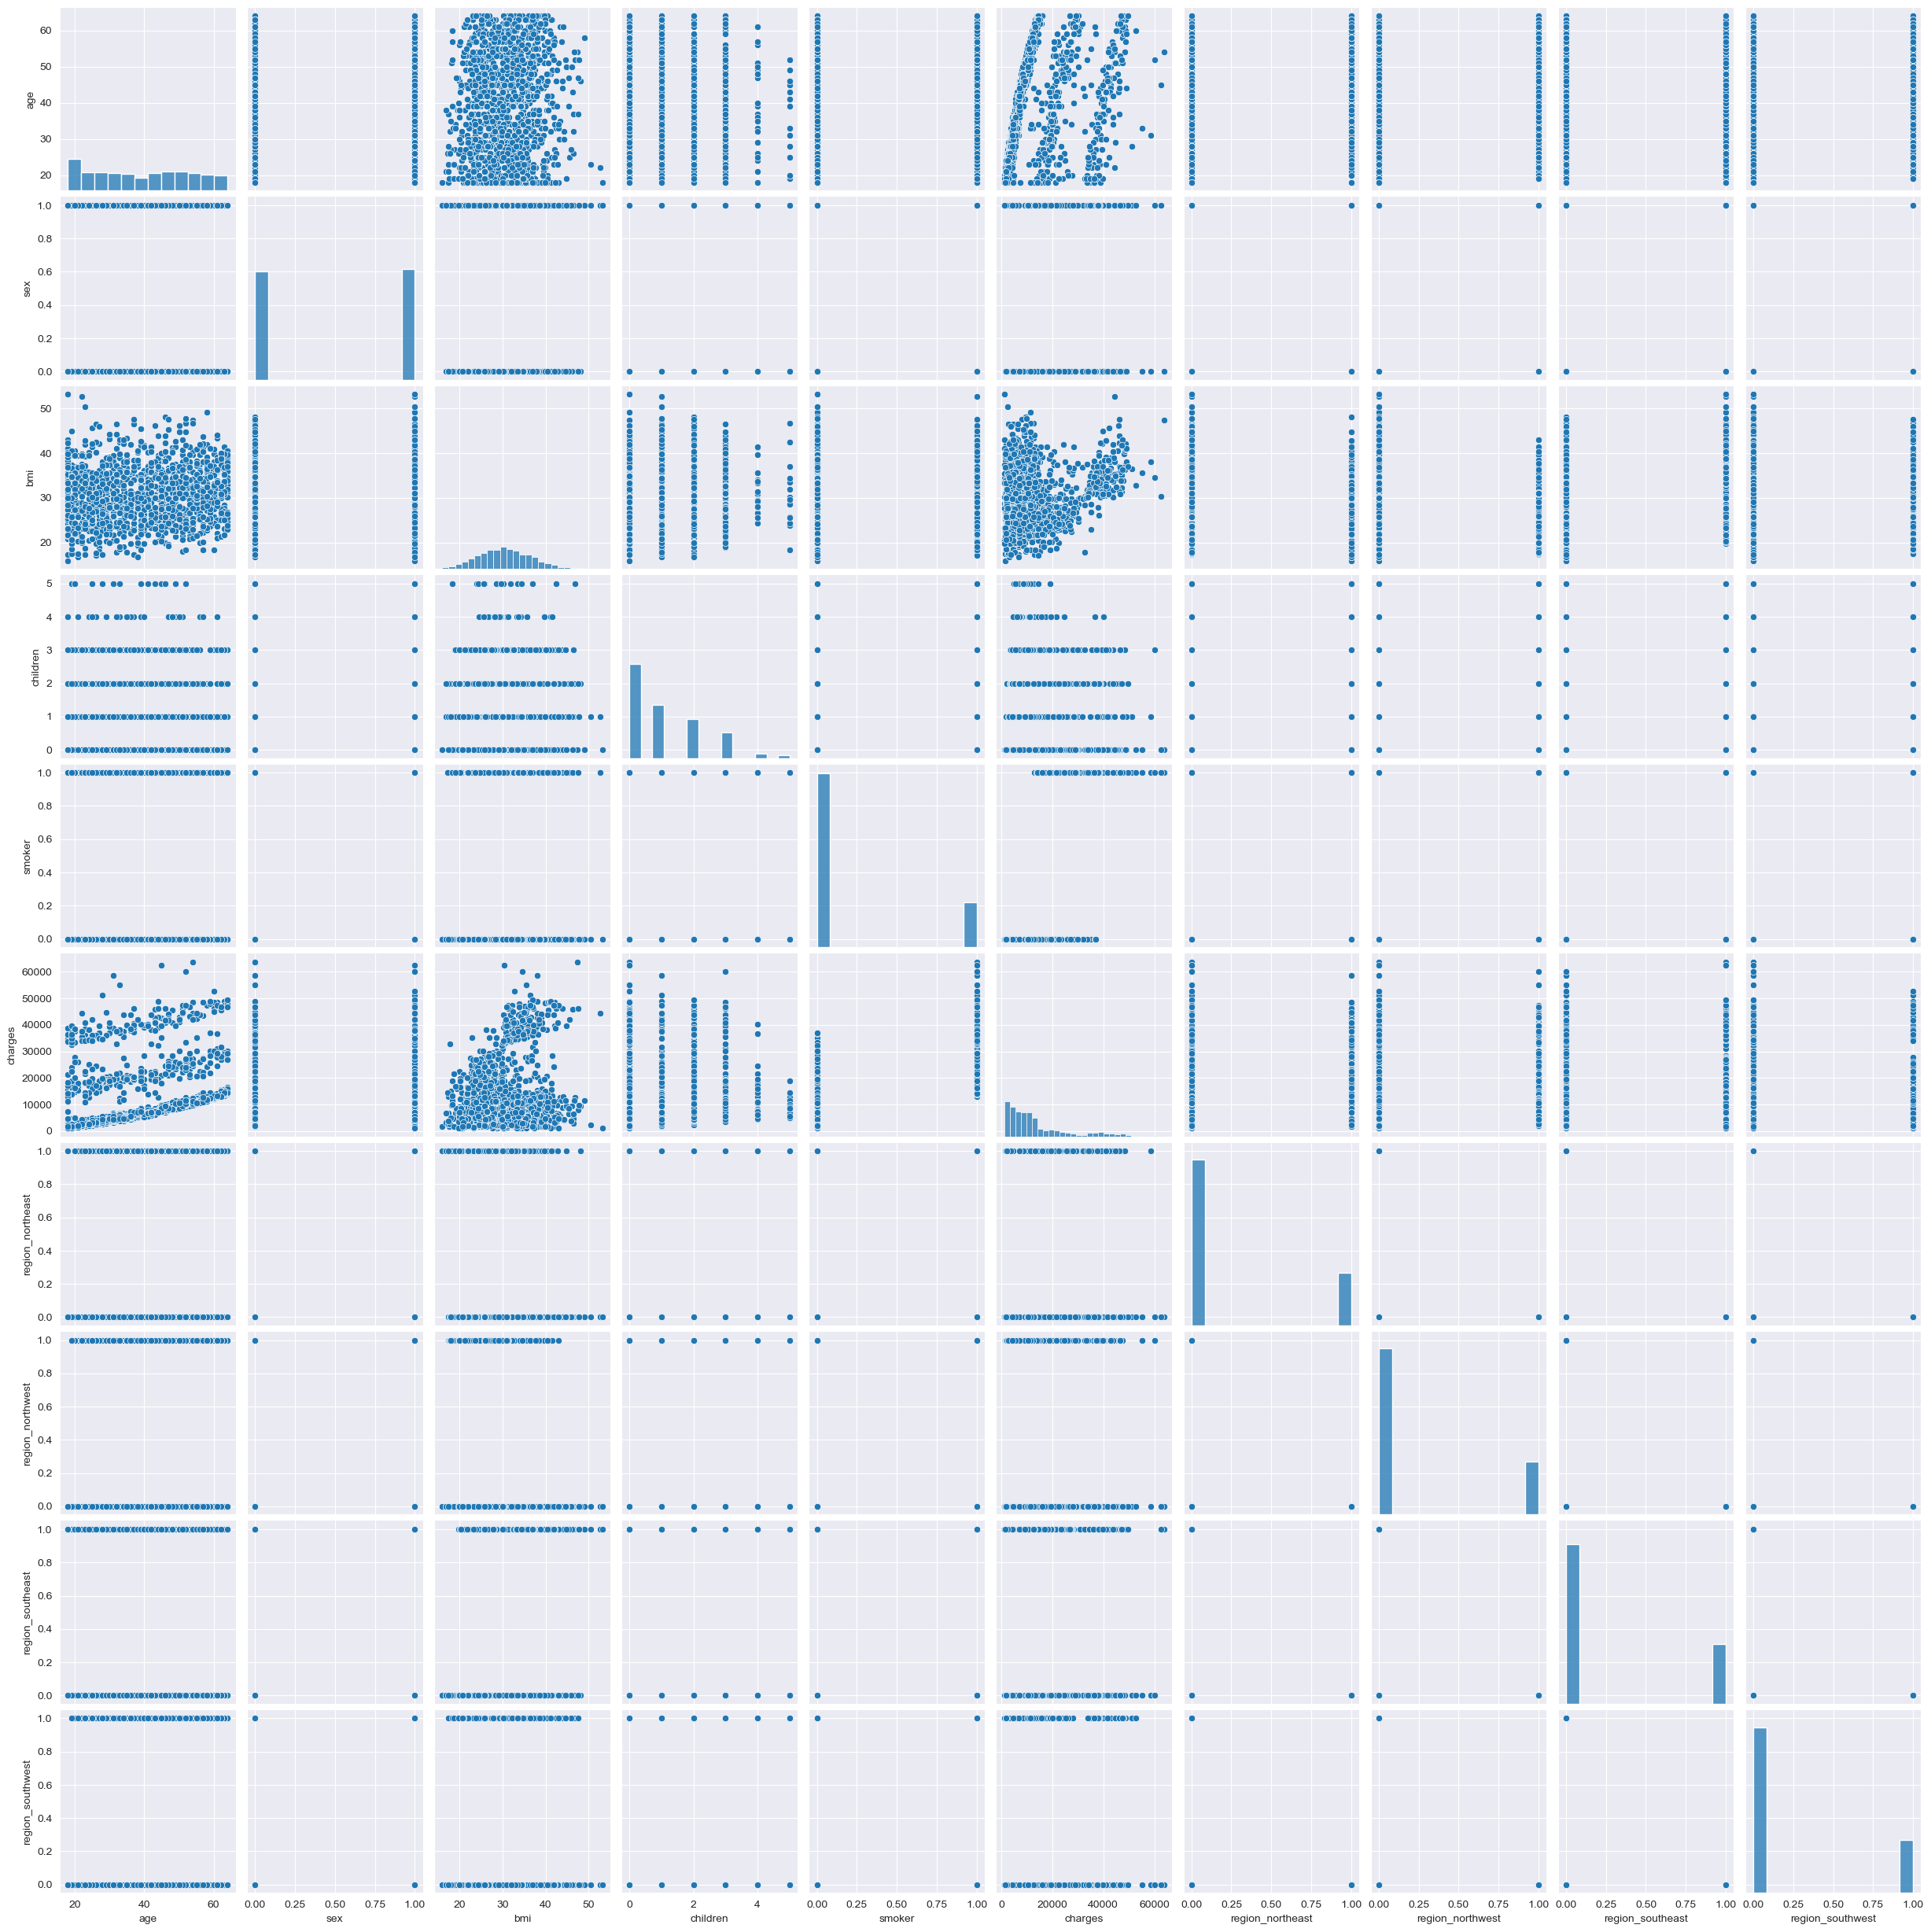

In [25]:
# viewing the updated encoded dataset's correlation with each feature 
sns.pairplot(df_encoded)

<Axes: xlabel='age', ylabel='charges'>

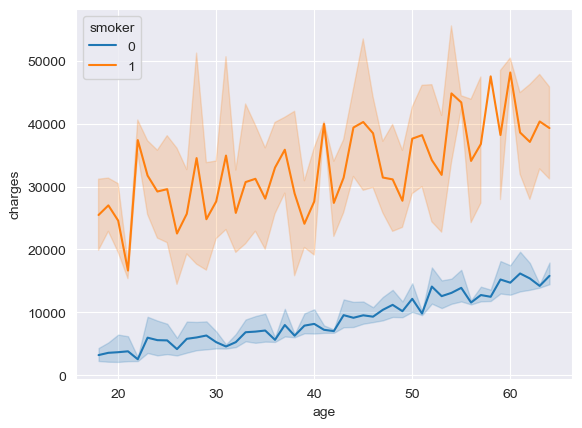

In [26]:
# viewing how much more smokers are getting charged for insurance vs non-smokers
sns.lineplot(data=df_encoded, x="age", y="charges", hue="smoker")

When we compare people with the same ages and then we separate people who smoke and do not smoke, we can see that the smokers are charged significantly higher vs the non-smokers. It is almost doubled if a person smokes.

# 2. Perform all the steps that are crucial for ensuring that the data fed into your models is of high quality and suitable for your needs.

In [27]:
# creating an instance of MinMaxScaler() class
scaler = MinMaxScaler()

I choose to use MinMaxScaler() because it is the standard approach for scaling for Neural Networks, also because the dataset does not have a normal/gaussian distribution.

In [28]:
# duplicated encoded dataframe
df_encoded_scaled = df_encoded

In [29]:
# only performing MinMaxScaler() on the non-categorical features
df_encoded_scaled[['age','bmi']] = scaler.fit_transform(df_encoded_scaled[['age','bmi']])

No need to scale out target variable therefore i did not include it on the columns that need to be scaled.

In [30]:
# preview of the scaled df
df_encoded_scaled.head()

age  sex       bmi  children  smoker      charges  region_northeast  \
0  0.021739    0  0.321227         0       1  16884.92400                 0   
1  0.000000    1  0.479150         1       0   1725.55230                 0   
2  0.217391    1  0.458434         3       0   4449.46200                 0   
3  0.326087    1  0.181464         0       0  21984.47061                 0   
4  0.304348    1  0.347592         0       0   3866.85520                 0   

   region_northwest  region_southeast  region_southwest  
0                 0                 0                 1  
1                 0                 1                 0  
2                 0                 1                 0  
3                 1                 0                 0  
4                 1                 0                 0

I have already encoded and given an explanation of why I chose to encode the categorical features in Question 1.

For Sex and Smoker:
"I just used map to encode this vs one-hot because since there is only two options it is easier to map the binary classes to 0 and 1."

For Region:
"I had to use one-hot encoding for the region feature because it does not have an order and rank, so I must split the feature into 4 separate features and one-hot encode it for best practices."

For Children:
"It is already encoded with an order and rank. For example, higher amount of children has a higher rank than lower amount of children."

In [31]:
# Converting the df to X and y
X = df_encoded_scaled.drop(columns=['charges'])
y = df_encoded_scaled['charges']

In [32]:
# splitting the df into an 80% train and 20% test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [33]:
# checking the shapes of the variables to make sure they are correct
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1069, 9) (268, 9) (1069,) (268,)


In [34]:
X_train

age  sex       bmi  children  smoker  region_northeast  \
1114  0.108696    1  0.230024         0       0                 1   
968   0.065217    1  0.263250         2       0                 1   
599   0.739130    0  0.580172         2       0                 0   
170   0.978261    1  0.686306         0       0                 0   
275   0.630435    0  0.286252         2       0                 1   
...        ...  ...       ...       ...     ...               ...   
1096  0.717391    0  0.511165         2       1                 1   
1131  0.195652    1  0.805488         2       0                 0   
1295  0.043478    1  0.162497         1       0                 0   
861   0.434783    0  0.323917         3       0                 0   
1127  0.369565    0  0.535378         2       0                 0   

      region_northwest  region_southeast  region_southwest  
1114                 0                 0                 0  
968                  0                 0                 0  
599                  1                 0                 0  
170                  0                 1                 0  
275                  0                 0                 0  
...                ...               ...               ...  
1096                 0                 0                 0  
1131                 0                 0                 1  
1295                 0                 0                 1  
861                  0                 0                 1  
1127                 0                 1                 0  

[1069 rows x 9 columns]

In [35]:
y_train

1114     2396.09590
968      3279.86855
599     33471.97189
170     13405.39030
275      9715.84100
           ...     
1096    44641.19740
1131     3693.42800
1295     1964.78000
861      7151.09200
1127     5836.52040
Name: charges, Length: 1069, dtype: float64

# 3. Build a neural network following the 5 steps in the NN model life-cycle as shown in figure 1 below.

In [36]:
# building a baseline model
def baseline_NN():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    #Output layer
    model.add(Dense(1, activation='linear'))
    # compiling the model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    model.summary()
    return model
model = baseline_NN()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1280      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11649 (45.50 KB)
Trainable params: 11649 (45.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
# fitting the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs =100)

Epoch 1/100
27/27 [==============================] - 0s 4ms/step - loss: 307296064.0000 - mae: 13133.9346 - val_loss: 303914208.0000 - val_mae: 12601.4766
Epoch 2/100
27/27 [==============================] - 0s 2ms/step - loss: 306921824.0000 - mae: 13121.4023 - val_loss: 303162848.0000 - val_mae: 12575.2959
Epoch 3/100
27/27 [==============================] - 0s 2ms/step - loss: 305205024.0000 - mae: 13059.6455 - val_loss: 299814336.0000 - val_mae: 12458.3252
Epoch 4/100
27/27 [==============================] - 0s 1ms/step - loss: 298626688.0000 - mae: 12834.7773 - val_loss: 289198592.0000 - val_mae: 12078.1904
Epoch 5/100
27/27 [==============================] - 0s 1ms/step - loss: 281571008.0000 - mae: 12209.3691 - val_loss: 264652992.0000 - val_mae: 11150.1729
Epoch 6/100
27/27 [==============================] - 0s 1ms/step - loss: 248291792.0000 - mae: 10883.3447 - val_loss: 222672864.0000 - val_mae: 9485.7812
Epoch 7/100
27/27 [==============================] - 0s 1ms/step - loss

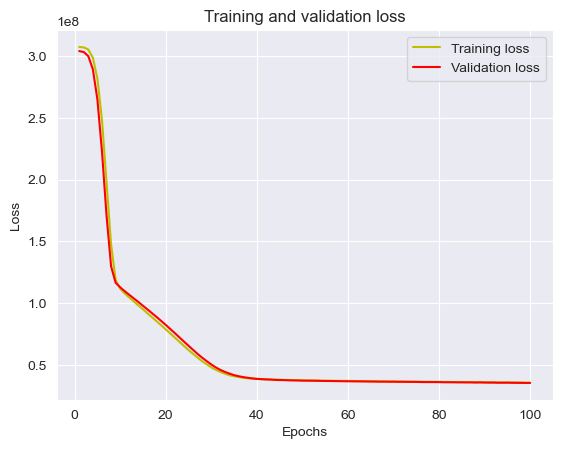

In [38]:
# plotting the training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

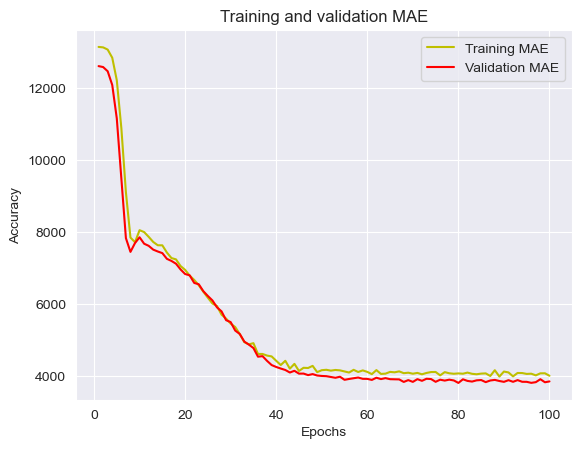

In [39]:
# plotting the training and validation MAE
acc = history.history['mae']
val_acc = history.history['val_mae']
plt.plot(epochs, acc, 'y', label='Training MAE')
plt.plot(epochs, val_acc, 'r', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [40]:
# predicting the first 100 vals of X_test
predictions = model.predict(X_test[:100])
print("Predicted values are: ", predictions)
print("Real values are: ", y_test[:100])

4/4 [==============================] - 0s 2ms/step
Predicted values are:  [[ 8003.502 ]
 [ 7202.2964]
 [13700.454 ]
 [30375.406 ]
 [ 8282.878 ]
 [12757.404 ]
 [28409.238 ]
 [ 1738.9359]
 [10242.163 ]
 [11051.546 ]
 [10502.043 ]
 [33642.676 ]
 [29918.816 ]
 [17982.303 ]
 [10382.825 ]
 [ 9235.505 ]
 [ 3916.4905]
 [32072.646 ]
 [ 3854.3262]
 [ 4999.8296]
 [ 3194.0698]
 [29236.057 ]
 [14340.7295]
 [30977.701 ]
 [30863.143 ]
 [ 5929.0234]
 [35452.004 ]
 [38192.254 ]
 [10938.347 ]
 [14105.419 ]
 [ 6179.4556]
 [12572.843 ]
 [ 1688.3956]
 [12341.626 ]
 [40843.37  ]
 [12198.026 ]
 [ 7371.041 ]
 [ 5784.628 ]
 [32116.4   ]
 [ 8806.419 ]
 [ 6366.1426]
 [28665.014 ]
 [34518.98  ]
 [11689.885 ]
 [ 7837.9644]
 [ 3398.6167]
 [ 5622.7383]
 [ 8655.822 ]
 [ 4671.417 ]
 [ 8643.337 ]
 [ 6365.376 ]
 [11016.747 ]
 [30226.922 ]
 [ 3285.2603]
 [10498.611 ]
 [ 9463.733 ]
 [10490.743 ]
 [ 3388.7236]
 [31408.932 ]
 [ 8998.991 ]
 [15107.054 ]
 [ 7692.1445]
 [12035.894 ]
 [ 2527.243 ]
 [16243.72  ]
 [10817.081 ]
 [

In [41]:
# checking the MSE and MAE of the test set
mse_neural, mae_neural = model.evaluate(X_test, y_test)
print('Mean squared error from neural net: ', mse_neural)
print('Mean absolute error from neural net: ', mae_neural)

9/9 [==============================] - 0s 750us/step - loss: 34723204.0000 - mae: 4064.7109
Mean squared error from neural net:  34723204.0
Mean absolute error from neural net:  4064.7109375


We can calculate on our 268 test set the average distance our model got compared to the actual values are:

4064.71 / 268 = 15.17

Therefore, on average our model is about $15.17 away from the real value.

In [42]:
# viewing the predictions
predictions

array([[ 8003.502 ],
       [ 7202.2964],
       [13700.454 ],
       [30375.406 ],
       [ 8282.878 ],
       [12757.404 ],
       [28409.238 ],
       [ 1738.9359],
       [10242.163 ],
       [11051.546 ],
       [10502.043 ],
       [33642.676 ],
       [29918.816 ],
       [17982.303 ],
       [10382.825 ],
       [ 9235.505 ],
       [ 3916.4905],
       [32072.646 ],
       [ 3854.3262],
       [ 4999.8296],
       [ 3194.0698],
       [29236.057 ],
       [14340.7295],
       [30977.701 ],
       [30863.143 ],
       [ 5929.0234],
       [35452.004 ],
       [38192.254 ],
       [10938.347 ],
       [14105.419 ],
       [ 6179.4556],
       [12572.843 ],
       [ 1688.3956],
       [12341.626 ],
       [40843.37  ],
       [12198.026 ],
       [ 7371.041 ],
       [ 5784.628 ],
       [32116.4   ],
       [ 8806.419 ],
       [ 6366.1426],
       [28665.014 ],
       [34518.98  ],
       [11689.885 ],
       [ 7837.9644],
       [ 3398.6167],
       [ 5622.7383],
       [ 8655

In [43]:
# viewing the first 100 values of the real val
real_vals = y_test[:100].reset_index(drop=True)

In [44]:
# viewing the real values
real_vals

0      8688.85885
1      5708.86700
2     11436.73815
3     38746.35510
4      4463.20510
         ...     
95    43254.41795
96     9504.31030
97     8232.63880
98     1674.63230
99     8604.48365
Name: charges, Length: 100, dtype: float64

Text(0.5, 0, 'Index')

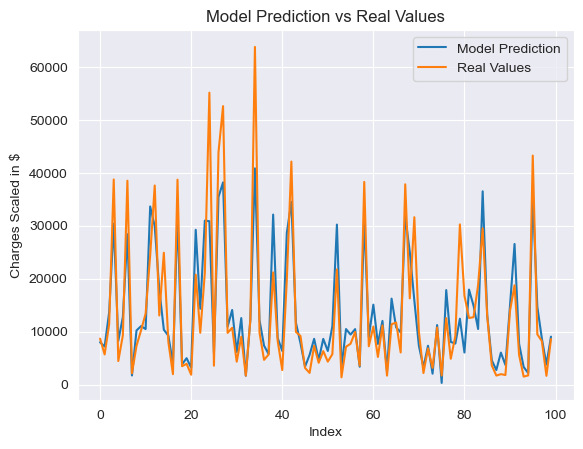

In [45]:
# plotting the model's predictions vs the real values of charges
plt.plot(predictions, label='Model Prediction')
plt.plot(real_vals, label='Real Values')
plt.title('Model Prediction vs Real Values')
plt.legend(loc='best')
plt.ylabel('Charges Scaled in $')
plt.xlabel('Index')

When we view our baseline model's performance predicting the test values, we can see that it is not far off from the real values.

In [46]:
keras_regressor = KerasRegressor(model=baseline_NN, random_state=42, epochs=100, verbose=1, validation_split=0.2)
params = {
    'epochs':[100, 200, 300, 400, 500],
    'batch_size': [16, 32, 64, 128]
}
grid_search = GridSearchCV(estimator=keras_regressor, param_grid=params, cv=3)

Using grid search to find the best epoch, and batch size for our baseline model.
The choices are: 100, 200, 300, 400, 500 for epoch and 16, 32, 64, 128 for the batch size

In [47]:
grid_search.fit(X_train, y_train)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               1280      
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11649 (45.50 KB)
Trainable params: 11649 (45.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
36/36 [==============================] - 0s 3ms/step - loss: 304820096.0000 - mae: 13206.1816 - val_loss: 320365312.0000 - val_mae: 12875.

GridSearchCV(cv=3,
             estimator=KerasRegressor(epochs=100, model=<function baseline_NN at 0x00000228D4AF9C60>, random_state=42, validation_split=0.2),
             param_grid={'batch_size': [16, 32, 64, 128],
                         'epochs': [100, 200, 300, 400, 500]})

In [48]:
grid_search.best_estimator_

KerasRegressor(
	model=<function baseline_NN at 0x00000228D4AF9C60>
	build_fn=None
	warm_start=False
	random_state=42
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=16
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=500
)

In [49]:
grid_search.best_params_

{'batch_size': 16, 'epochs': 500}

Grid search gave us a batch size of 16 and an epoch of 500 for our baseline model

In [50]:
# Creating a tuned model
def build_model(hp):
    model = Sequential()
    count = 0
    for i in range(hp.Int(name='layers_num',min_value=2,max_value=5)):
        if count==0:
            model.add(Dense(hp.Int(name='units'+str(i),min_value=128,max_value=256,step=64),
                            activation='relu',
                            input_dim=X_train.shape[1],
                            kernel_regularizer='l2'
                            ))
            model.add(Dropout(hp.Choice(name='dropout'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
        else:
            model.add(Dense(hp.Int(name='units'+str(i),min_value=16,max_value=64,step=8),
                            activation='relu',
                            kernel_regularizer='l2'
                            ))
            model.add(Dropout(hp.Choice(name='dropout'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
        count += 1
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    return model

Creating a tuned model with:
range of 2-5 hidden layers,
range of 128-256 neurons with a step of 64, using a ReLU activation function, a dropout rate of 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, and a l2 regularize for our first layer,
range of 16-64 neurons with a step of 8, using a ReLU activation function, a dropout rate of 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, and a l2 regularize for the rest of the hidden layers,
a linear activation function for our output layer,
compiled with MSE as our loss, adam as our optimizer, and MAE as our metric.

added l2 and dropout to help prevent overfitting.


In [51]:
tuner = kt.RandomSearch(build_model,
                        objective='val_loss',
                        max_trials=10,
                        directory='keras_tunes3',
                        project_name='KTuner')

tuner.search(X_train,y_train,epochs=100, validation_split=0.2)

Reloading Tuner from keras_tunes3\KTuner\tuner0.json


Our objective is to minimize our validation's loss

In [52]:
tuner.get_best_hyperparameters()[0].values

{'layers_num': 4,
 'units0': 192,
 'dropout0': 0.2,
 'units1': 48,
 'dropout1': 0.3,
 'units2': 40,
 'dropout2': 0.1,
 'units3': 48,
 'dropout3': 0.1,
 'units4': 16,
 'dropout4': 0.3}

In [53]:
tuned_model = tuner.get_best_models(num_models=1)[0]

In [54]:
tuned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 192)               1920      
                                                                 
 dropout (Dropout)           (None, 192)               0         
                                                                 
 dense_1 (Dense)             (None, 48)                9264      
                                                                 
 dropout_1 (Dropout)         (None, 48)                0         
                                                                 
 dense_2 (Dense)             (None, 40)                1960      
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense_3 (Dense)             (None, 48)                1

In [71]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csv_logger = CSVLogger('training.log.csv')
early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
callbacks_list = [checkpoint, csv_logger, early_stop]

After finding the best tuned model, we're going to be tracking model checkpoints, and log our model's training, as well as adding early stopping to our tuned model's callback.
ModelCheckpoint so we save our best model at the moment in case of an emergency shutdown.
CSVLogger to log our model's training in case of errors or possible data loss of an emergency shutdown.
EarlyStopping to prevent overfitting when the validation loss is not descreasing anymore.

In [72]:
tuned_history = tuned_model.fit(X_train,y_train, epochs=100, validation_split=0.2, callbacks=callbacks_list)

Epoch 1/100
 1/27 [>.............................] - ETA: 0s - loss: 37831720.0000 - mae: 3673.1567
Epoch 1: val_loss improved from inf to 20825612.00000, saving model to best_model.hdf5
27/27 [==============================] - 0s 3ms/step - loss: 29501170.0000 - mae: 3388.1633 - val_loss: 20825612.0000 - val_mae: 2513.5979
Epoch 2/100
 1/27 [>.............................] - ETA: 0s - loss: 42131960.0000 - mae: 3849.6553
Epoch 2: val_loss improved from 20825612.00000 to 20749078.00000, saving model to best_model.hdf5
27/27 [==============================] - 0s 3ms/step - loss: 28416482.0000 - mae: 3176.6416 - val_loss: 20749078.0000 - val_mae: 2685.8196
Epoch 3/100
 1/27 [>.............................] - ETA: 0s - loss: 11664803.0000 - mae: 2337.2935
Epoch 3: val_loss did not improve from 20749078.00000
27/27 [==============================] - 0s 2ms/step - loss: 29871652.0000 - mae: 3372.1226 - val_loss: 22665512.0000 - val_mae: 2480.7190
Epoch 4/100
 1/27 [>........................

C:\Users\xxryk\anaconda3\envs\school\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 0s 2ms/step - loss: 30408230.0000 - mae: 3461.1875 - val_loss: 20841216.0000 - val_mae: 2559.3694
Epoch 5/100
 1/27 [>.............................] - ETA: 0s - loss: 18955640.0000 - mae: 2577.6602
Epoch 5: val_loss did not improve from 20749078.00000
27/27 [==============================] - 0s 2ms/step - loss: 30320526.0000 - mae: 3270.7334 - val_loss: 21615686.0000 - val_mae: 2467.5435
Epoch 6/100
 1/27 [>.............................] - ETA: 0s - loss: 28351952.0000 - mae: 3391.1724
Epoch 6: val_loss did not improve from 20749078.00000
27/27 [==============================] - 0s 2ms/step - loss: 28232488.0000 - mae: 3172.5105 - val_loss: 21470634.0000 - val_mae: 2558.0554
Epoch 7/100
 1/27 [>.............................] - ETA: 0s - loss: 29124900.0000 - mae: 3293.8638
Epoch 7: val_loss did not improve from 20749078.00000
27/27 [==============================] - 0s 2ms/step - loss: 31398398.0000 - mae: 3387.5796 - val_loss: 21882446.0000 - v

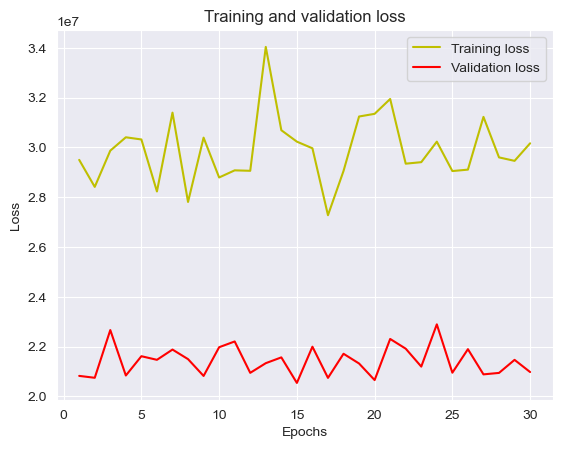

In [73]:
# plotting the training and validation loss
loss = tuned_history.history['loss']
val_loss = tuned_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can see that our tuned model was stopped early at 30 epochs after the validation set's loss failed to decrease after 15 tries.

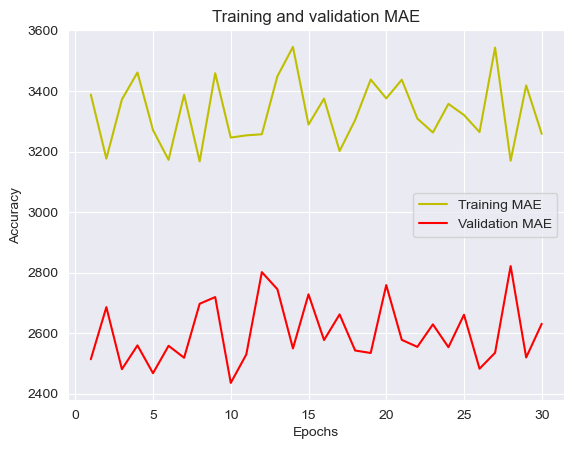

In [74]:
# plotting the training and validation MAE
acc = tuned_history.history['mae']
val_acc = tuned_history.history['val_mae']
plt.plot(epochs, acc, 'y', label='Training MAE')
plt.plot(epochs, val_acc, 'r', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We can see that our tuned model was stopped early at 30 epochs after the validation set's loss failed to decrease after 15 tries.

In [75]:
# predicting the first 100 vals of X_test
tuned_predictions = tuned_model.predict(X_test[:100])
print("Predicted values are: ", tuned_predictions)
print("Real values are: ", y_test[:100])

4/4 [==============================] - 0s 666us/step
Predicted values are:  [[ 9021.549 ]
 [ 6987.4785]
 [13669.684 ]
 [34326.953 ]
 [ 5590.2676]
 [10672.201 ]
 [37801.457 ]
 [ 3337.2998]
 [ 9091.137 ]
 [11442.841 ]
 [13647.665 ]
 [28490.547 ]
 [33934.387 ]
 [14737.088 ]
 [ 9778.955 ]
 [ 8600.569 ]
 [ 3123.967 ]
 [35411.207 ]
 [ 3904.1235]
 [ 5154.16  ]
 [ 2819.273 ]
 [26347.887 ]
 [12397.164 ]
 [28213.027 ]
 [37183.312 ]
 [ 5813.042 ]
 [45947.414 ]
 [40357.637 ]
 [11548.998 ]
 [12762.35  ]
 [ 6499.025 ]
 [10430.02  ]
 [ 2802.5159]
 [12378.879 ]
 [59079.984 ]
 [11308.4795]
 [ 6714.3257]
 [ 7715.5654]
 [22569.135 ]
 [ 9821.031 ]
 [ 5660.2505]
 [20525.945 ]
 [38817.914 ]
 [10760.125 ]
 [ 9640.432 ]
 [ 4447.987 ]
 [ 5195.4854]
 [ 8503.943 ]
 [ 5506.1694]
 [ 7559.2695]
 [ 5834.6714]
 [ 7770.182 ]
 [24270.594 ]
 [ 2301.2812]
 [ 7969.879 ]
 [ 8941.955 ]
 [10517.686 ]
 [ 4940.226 ]
 [35428.727 ]
 [ 8280.289 ]
 [14202.34  ]
 [ 6531.186 ]
 [12637.428 ]
 [ 3033.3394]
 [13680.957 ]
 [12986.941 ]


In [76]:
mse_neural, mae_neural = tuned_model.evaluate(X_test, y_test)
print('Mean squared error from neural net: ', mse_neural)
print('Mean absolute error from neural net: ', mae_neural)

9/9 [==============================] - 0s 921us/step - loss: 20966922.0000 - mae: 2811.7842
Mean squared error from neural net:  20966922.0
Mean absolute error from neural net:  2811.7841796875


When comparing to our baseline model we can see that we improved significantly our average distance from the tuned model's prediction vs the real value decreased.

2811.78/268 = 10.49

Therefore, on average our tuned model is about $10.49 away from the real value.

4064.71 was the baseline model's MAE compared to 2811.78 for our tuned model.

Text(0.5, 0, 'Index')

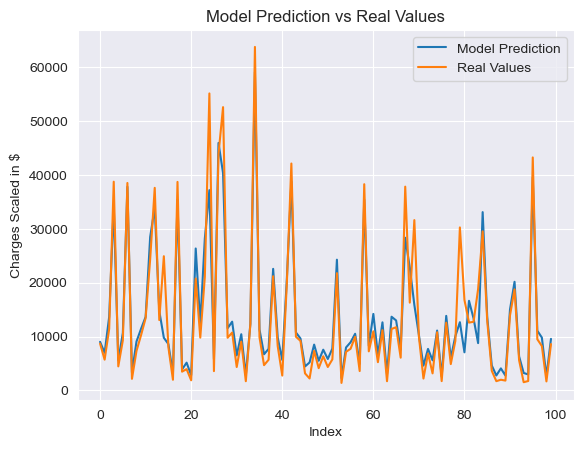

In [77]:
# plotting the model's predictions vs the real values of charges
plt.plot(tuned_predictions, label='Model Prediction')
plt.plot(real_vals, label='Real Values')
plt.title('Model Prediction vs Real Values')
plt.legend(loc='best')
plt.ylabel('Charges Scaled in $')
plt.xlabel('Index')

We can observe that our tuned model performs better than our baseline as the blue line is closer and tighter with the orange line.

# 4. Use TensorBoard for visualization of model performance.

In [78]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks_list = [tensorboard_callback]
tuned_history = tuned_model.fit(X_train,y_train, epochs=100, validation_split=0.2, callbacks=callbacks_list)

Epoch 1/100
27/27 [==============================] - 0s 4ms/step - loss: 30120420.0000 - mae: 3377.3281 - val_loss: 21029576.0000 - val_mae: 2475.7698
Epoch 2/100
27/27 [==============================] - 0s 3ms/step - loss: 30803956.0000 - mae: 3360.4404 - val_loss: 21814038.0000 - val_mae: 2511.1721
Epoch 3/100
27/27 [==============================] - 0s 3ms/step - loss: 30493994.0000 - mae: 3440.8984 - val_loss: 21484864.0000 - val_mae: 2518.7595
Epoch 4/100
27/27 [==============================] - 0s 3ms/step - loss: 31225732.0000 - mae: 3378.8862 - val_loss: 23103350.0000 - val_mae: 2470.7422
Epoch 5/100
27/27 [==============================] - 0s 3ms/step - loss: 32263656.0000 - mae: 3425.8420 - val_loss: 21622470.0000 - val_mae: 2547.1030
Epoch 6/100
27/27 [==============================] - 0s 4ms/step - loss: 30815824.0000 - mae: 3386.4729 - val_loss: 21461466.0000 - val_mae: 2440.0486
Epoch 7/100
27/27 [==============================] - 0s 3ms/step - loss: 28798720.0000 - mae: 

retraining our tuned model to make use of the TensorBoard callbacks.

In [79]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

## Screenshots from Tensorboard

### Single Run

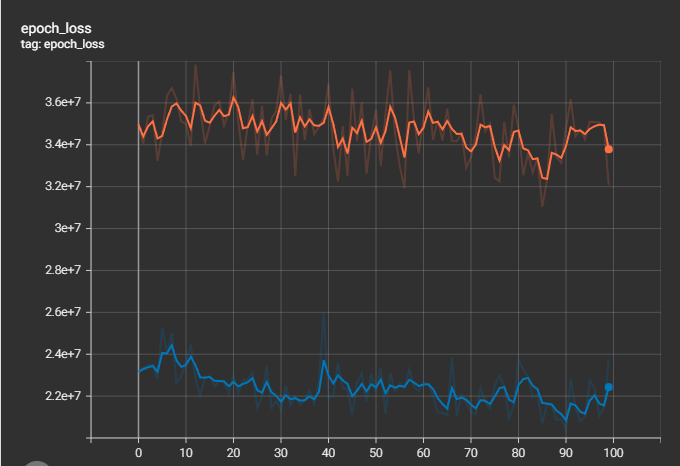

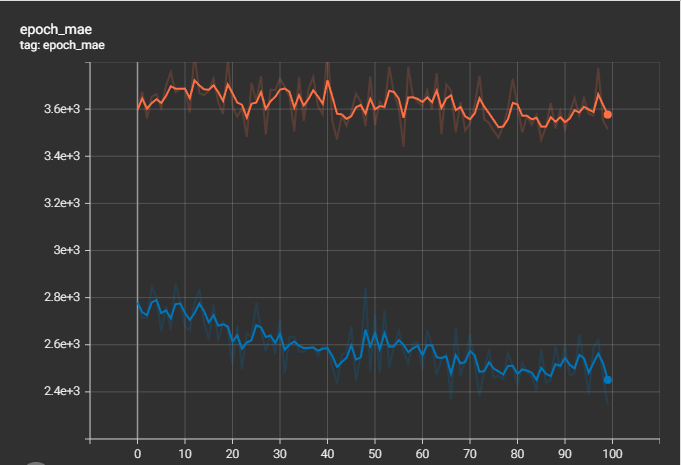

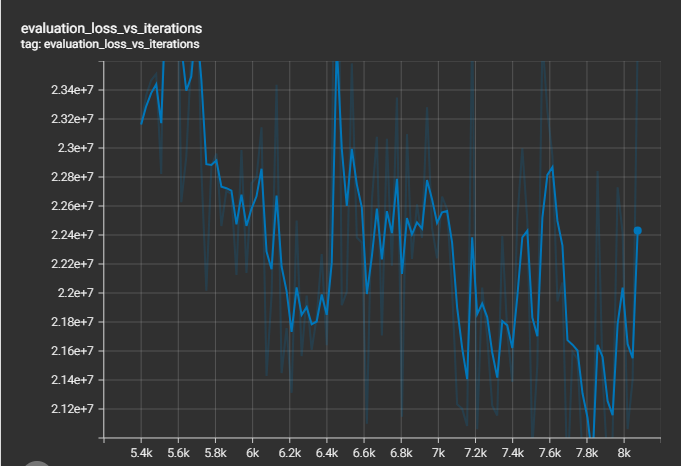

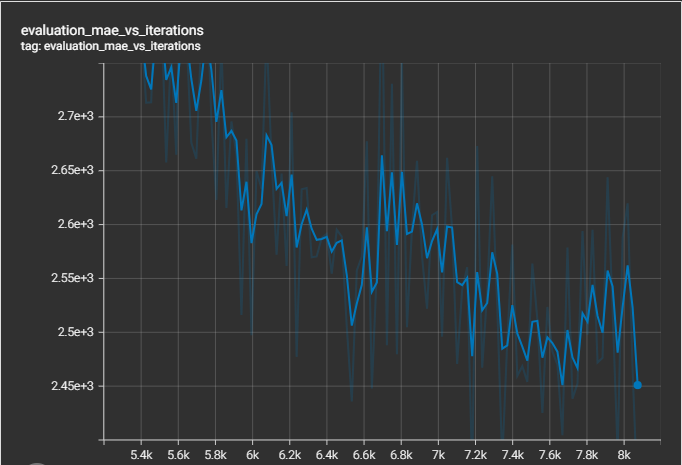

When we compare the train and validation (evaluation) losses we can see that the validation decreases as more iterations occur where as the train set is flatter. Part of the reason this could be, is because when we hyperparameter tuned the model our objective was set to lower our validation (evaluation) loss. Therefore it focused more on lowering our validation loss compared to our training. It is the same with our Mean Absolute Error for our train and validation set. This is due to MAE being correlated with our loss.

### 5 Runs Plotted

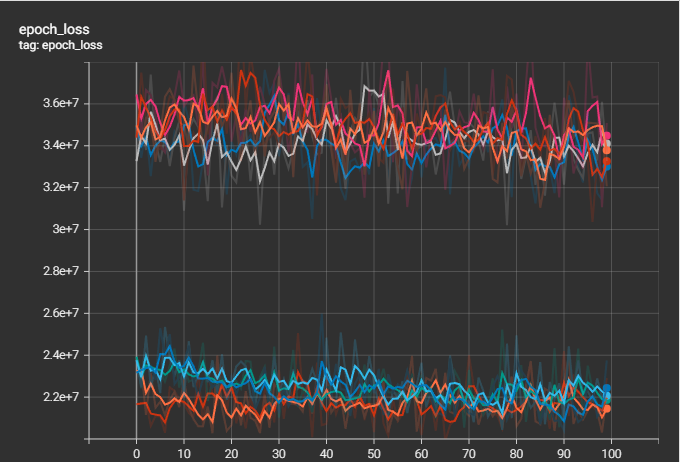

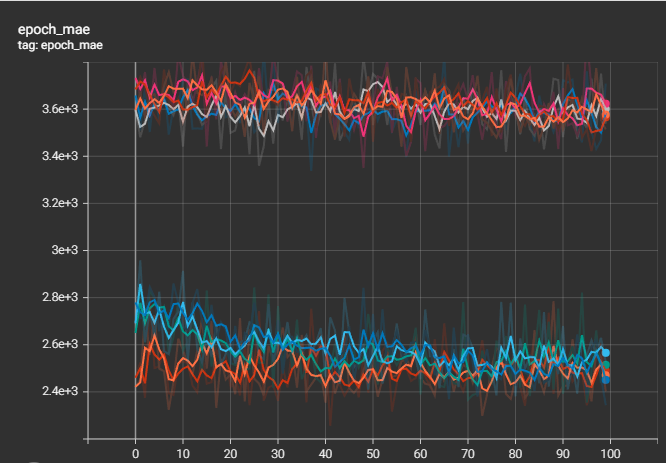

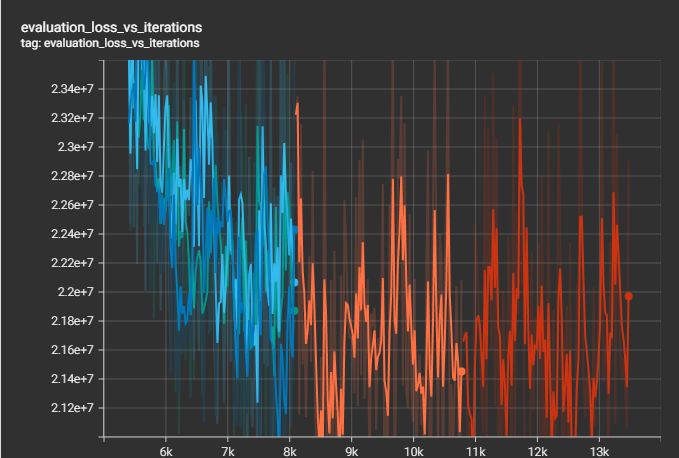

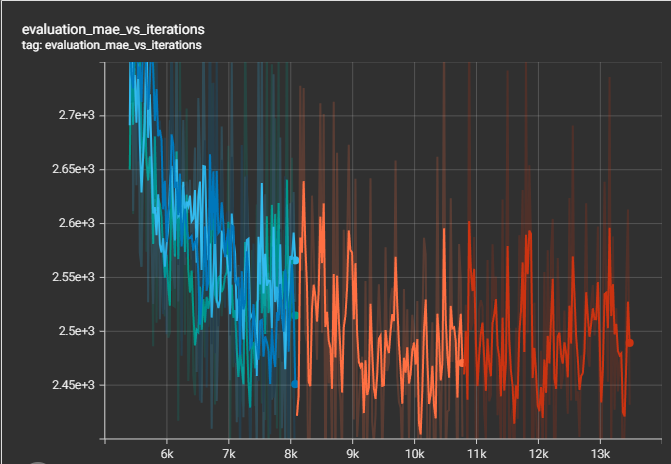

After looking at 5 different runs on our train and validation (evaluation) losses and MAE, we come to the same conclusion. Generally all 5 trials prioritized to lower our evaluation losses and in turn, our MAE as well.

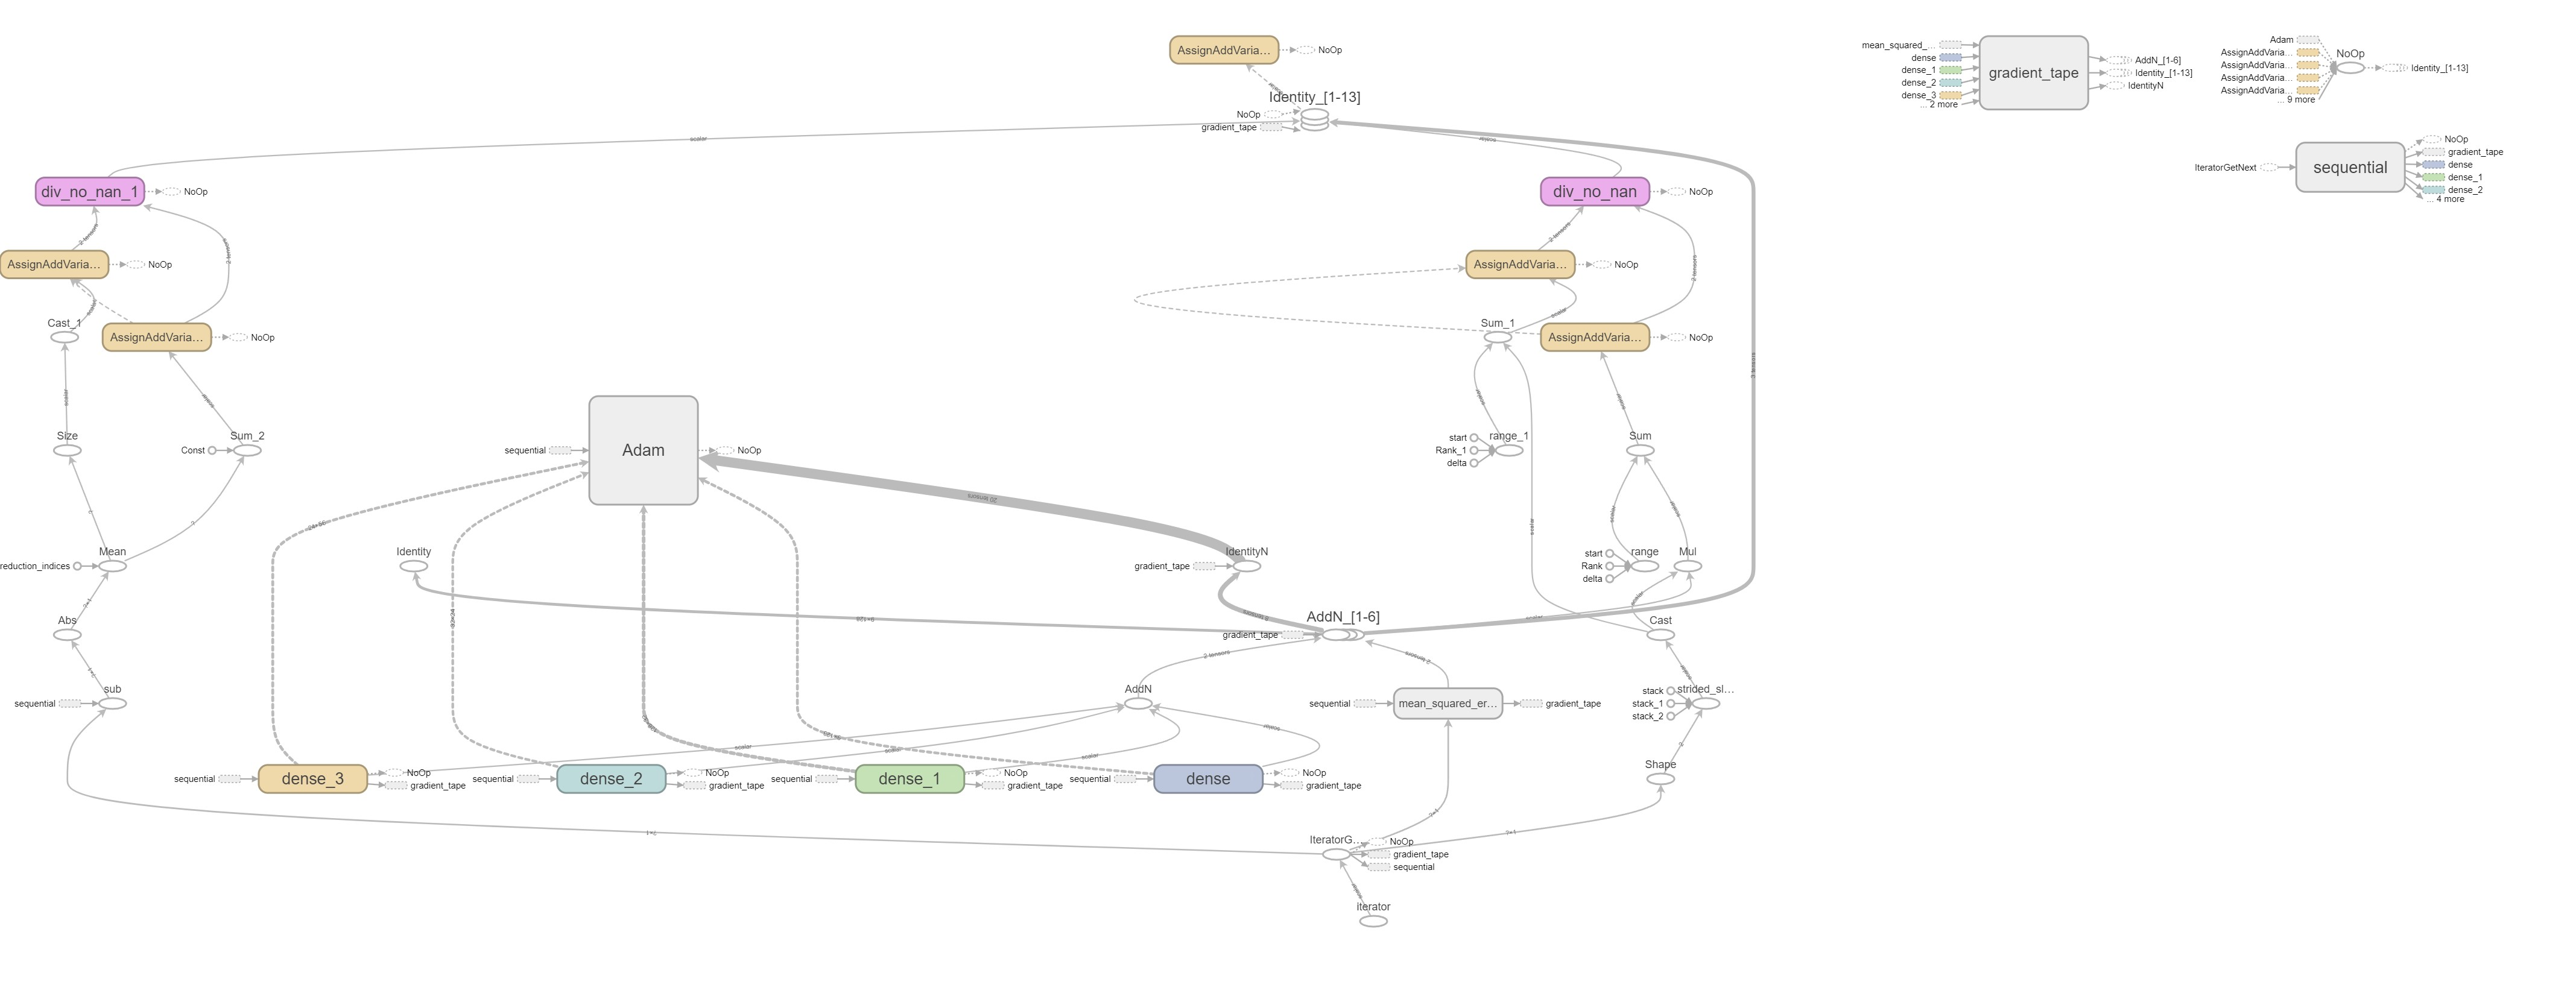

This is a visual of our hyper-parameter tuned model's architect.

# 5. Write a conclusion and recommendation.

After observing our models, we can conclude that our hyper-parameter tuned model performed significantly better than our baseline model. However, our hyper-parameter tuned model is a more complex neural network, having 4 hidden layers and 15,161 parameters. This could lead to overfitting as our dataset is very small. It is not ideal to run such a complex neural network on a dataset with only a size of 1338 points with 1 being a duplicate, therefore, technically only 1337. The dataset encompasses a combination of categorical and numerical attributes. Notably, the categorical attributes consist of 'sex,' 'smoker,' and 'region,' whereas the numerical attributes encompass 'age,' 'bmi,' 'children,' and 'charges'. Given that our target class consists of continuous numerical values, our task can be characterized as a regression problem. The categorical features were identified as nominal in nature, prompting the utilization of one-hot encoding to represent them. One-hot encoding preserves the unordered nature of categories and does not introduce any hierarchy among the categorical features. The children feature was left untouched because of the hierarchy of the number or children a person has. 

I would advise considering one of two options: acquiring a larger dataset if the intention is to employ a more complex model, or alternatively, opting for a simpler model given the limited dataset size. The utilization of deep learning techniques is not recommended for this dataset. Instead, machine learning models like random forests, as well as various regression models such as linear regression, lasso regression, and ridge regression, are more suitable choices and are likely to yield superior results.